This notebook implements a modified H-score and explores its properties. 

The modified H-score is calculated by introducing 'invisible trips'/artificial heterogeneity into each cluster. (Essentially what we are doing to the H-score [formula](https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/) is bumping up the cluster size when we calculate the entropy of C conditioned on K, but calculating the entropy of C with the real original sample size.) 

The idea is to penalize small bins (particularly single-trip bins, which would have a homogeneity score of 1 despite not providing us with much information/confidence). At the same time, we still want to capture the fact that we use the single-trip bins in our predictions, so we don't want to ignore them entirely. 

We expect this modification to degrade the H-score in all scenarios (H can equal 1 if a bin contains an infinite number of identical trips, or if there are an infinite number of single-trip bins). More importantly, small bins would be more affected than large bins, reflecting the greater confidence we have in our predictions when we have more trips in a bin. The rest of this notebook allows us to explore this modified score in further detail. 

### imports

In [1]:
import pandas as pd
import numpy as np
import geojson as gj
import sklearn.cluster as sc
import sklearn.metrics.pairwise as smp
import sklearn.metrics as sm

In [2]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster._supervised import check_clusterings
from sklearn.metrics.cluster import entropy
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import mutual_info_score

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

In [4]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### define performance metrics

In [84]:
def H_score(df):
    """ Calculated the standard homogeneity score. This should return the same 
        value as sklearn's homogeneity_score(), though the implementation is
        slightly different. 
        
        Args:
            df: DataFrame containing contingency matrix for true labels and bins
    """
    C = df.shape[0]
    N = df.sum().sum()
    entropy_C = 0
    entropy_CK = 0
    for c in range(C):
        n_c = df.iloc[c].sum()
#         print('samples w label c', n_c)
        if n_c == 0:
            continue
        entropy_C += (n_c/N) * (np.log(n_c) - np.log(N))
        
        for k in range(df.shape[1]):
            n_ck = df.iloc[c, k]
            n_k = df[df.columns[k]].sum() # number of samples in cluster k
            
            if n_k > 0 and n_ck > 0:
#                 print('samples w label c, cluster k', n_ck)
#                 print('samples in cluster k', n_k)
                entropy_CK += (n_ck/N) * (np.log(n_ck) - np.log(n_k))
#     print('entropy_CK', entropy_CK)
#     print('entropy_C', entropy_C)
    H = 1 - (entropy_CK/entropy_C) if entropy_C else 1.0
    return H

In [69]:
def H_score_modified(df, t=1):
    """ Calculated the modified homogeneity score, in which t 'invisible trips'
        are introduced to penalize bins with very few trips. This should return 
        a value that is smaller than sklearn's homogeneity_score().
        
        Args:
            df: DataFrame containing contingency matrix for true labels and bins
            k (int): number of 'invisible trips' to introduce
    """
    C = df.shape[0]
    N = df.sum().sum()
    entropy_C = 0
    entropy_CK = 0
    for c in range(C):
        n_c = df.iloc[c].sum() # number of samples with label c
        if n_c == 0:
            continue
        entropy_C += (n_c/N) * (np.log(n_c) - np.log(N+t))
#         print('entropy_C', entropy_C)
        
        for k in range(df.shape[1]):
            n_ck = df.iloc[c, k] # number of samples in cluster k with label c
            n_k = df[df.columns[k]].sum() # number of samples in cluster k
            if n_ck > 0:
                entropy_CK += (n_ck/N) * (np.log(n_ck) - np.log(n_k + t))
#     print('entropy_CK', entropy_CK)
#     print('entropy_C', entropy_C)
    H = 1 - (entropy_CK/entropy_C)
    return H

In [7]:
# for plotting
def plot_stacked_bars(df, fig=None, ax=None):
    if not (fig and ax):
        fig, ax = plt.subplots(1, 1)
    X = range(df.shape[1])
    for i in range(df.shape[0]):
        bottom=np.sum(df[:i], axis =0)
        ax.bar(X, df.iloc[i], bottom=bottom)
    ax.set_xlabel('bin')
    ax.set_ylabel('trip count')
#     plt.show()

check that I implemented the H-score correctly

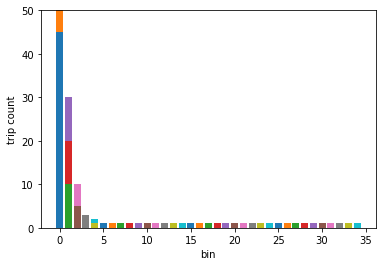

In [8]:
label_true = [0]*45 + [1]*5 + [2]*10 + [3]*10 + [4]*10 + [5]*5 + [6]*5 + [7]*3 + list(range(8, 40))
bin_pred = [1]*50 + [2]*30 + [3]*10 + [4]*3 + [5]*2 + list(range(6, 36))
df = pd.DataFrame(contingency_matrix(label_true, bin_pred, sparse=False))

plot_stacked_bars(df)
plt.show()

In [70]:
error = 1e-10
print("sklearn H-score:\t\t", homogeneity_score(label_true, bin_pred))
print("my H-score implementation:\t", H_score(df))
assert (H_score(df) - homogeneity_score(label_true, bin_pred)) < error 
print("H-score w/ penalty:\t\t", H_score_modified(df))

sklearn H-score:		 0.8286383846991637
my H-score implementation:	 0.8286383846991641
H-score w/ penalty:		 0.7537256832350768


### explore the modified H-score with some example data

In [10]:
def gen_clusters(N, K):
    """ Generates example data for N trips, split evenly among K homogeneous clusters. 
        Returns a dataframe containing the contingency matrix.
    
        Args:
            N (int): total number of trips
            K (int): number of clusters. K <= N
    """
    assert K <= N
    n_k = N // K # number of samples per cluster
    label_true = np.concatenate([[i]*n_k for i in range(K)])
    df = pd.DataFrame(contingency_matrix(label_true, label_true, sparse=False))
    return df

#### example 1: 

In this example, we assume that there are N trips that are split evenly into K homogeneous clusters, with each cluster containing N//K trips. 

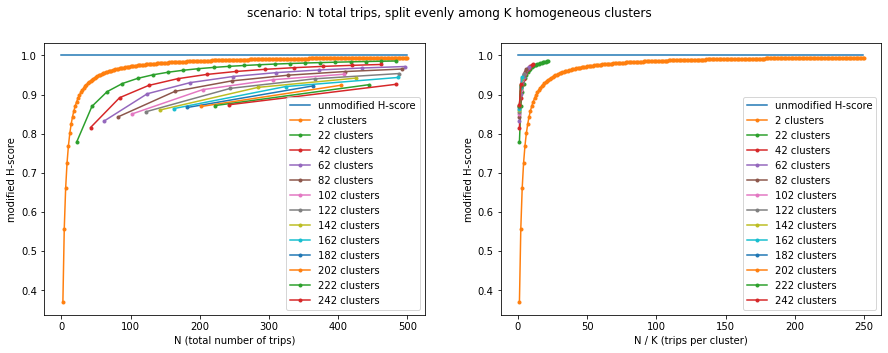

In [11]:
# generate a comparison graph
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5))
ax1.plot([1]*500, label="unmodified H-score")
ax2.plot([1]*250, label="unmodified H-score")
for K in range(2, 252, 20):
    if K == 1: continue # TODO: need to handle if 1 cluster
    X_N = []
    X_NK = []
    modified_H_scores1 = []
    modified_H_scores2 = []
    
    for N in range(K, 501):
        if N%K==0:
            modified_H_score = H_score_modified(gen_clusters(N, K))
            modified_H_scores1 += [modified_H_score]
            modified_H_scores2 += [modified_H_score]
            X_N += [N]
            X_NK += [N//K]
            
    ax1.plot(X_N, modified_H_scores1, '.-', label="{:d} clusters".format(K))
    ax2.plot(X_NK, modified_H_scores2, '.-', label="{:d} clusters".format(K))

    
fig.suptitle("scenario: N total trips, split evenly among K homogeneous clusters")
ax1.set_xlabel("N (total number of trips)")
ax1.set_ylabel("modified H-score")
ax2.set_xlabel("N / K (trips per cluster)")
ax2.set_ylabel("modified H-score")
ax1.legend()
ax2.legend()
plt.show()


As expected, the modified H-score approaches 0 as the number of trips/bin goes to infinity, reflecting a greater confidence in larger bins and penalizing bins with fewer trips. Compare this to the original H-score, which is artificially high for small bins. 

For the same number of trips/bin, the modified H-score is higher when there are more clusters. (Not really sure how to interpret this, though...)

#### example 2

We can examine the specific case in which there are N trips, each in its own cluster. (This is basically zooming in on a slice of the above graph on the right at N/K = 1)

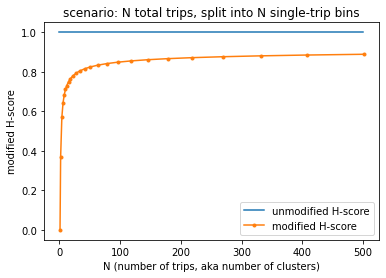

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot([1]*500, label="unmodified H-score")
N = np.concatenate((np.array([1, 2, 4, 6, 8]), np.logspace(1, 2.7, num=20).astype(int)))
modified_H_scores = np.empty(len(N))

for i in range(len(N)):
    n = N[i]
    if n == 1: continue # TODO: need to handle if 1 cluster
    modified_H_scores[i] = H_score_modified(gen_clusters(n, n))

ax.plot(N, modified_H_scores, '.-', label="modified H-score")

ax.set_title("scenario: N total trips, split into N single-trip bins")
ax.set_xlabel("N (number of trips, aka number of clusters)")
ax.set_ylabel("modified H-score")
plt.legend()
plt.show()

This is an interesting property, though not intended: as the number of single-trip bins increases, the modified H-score increases (it actually approaches 1 as N goes to infinity). I can't think of any authentic narrative interpretation we can make of this (but this seems to be a property of the raw H-score too, not unique to the modification - see below). Still, for all these cases, the modified H-score is less than 1, which is good because we want to avoid an artificially high H-score for single-trip bins. 

Here, we quickly check that the original H-score also has the property that it increases as the number of bins increases (while the number of trips/bin stays the same). 

In this example, each bin has 10 trips (9 with one label and 1 with a different label). We vary the number of bins and see how it affects the H-score. 

In [13]:
label_true = [1]*99 + [0]*1 + [2]*99 + [0]*1
bin_pred = [1]*100 + [2]*100
print(homogeneity_score(label_true, bin_pred))
print(H_score_modified(pd.DataFrame(contingency_matrix(label_true, bin_pred))))

label_true = [1]*99 + [0]*1
bin_pred = [1]*100
print(homogeneity_score(label_true, bin_pred))
print(H_score_modified(pd.DataFrame(contingency_matrix(label_true, bin_pred))))


0.9245483248000907
0.9117352209655136
1.5674036237692443e-14
0.0


In [18]:
print(H_score_modified(pd.DataFrame(contingency_matrix([0, 1, 2, 3], [0, 0, 2, 2]))))
print(H_score_modified(pd.DataFrame(contingency_matrix([0, 1, 2], [0, 0, 0]))))

0.31739380551401464
0.0


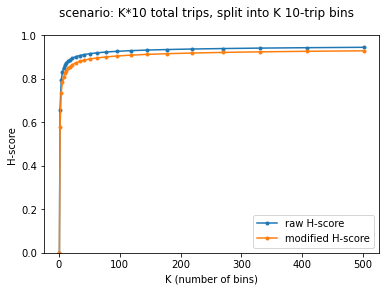

In [15]:
fig, ax = plt.subplots(1, 1)
K = np.concatenate((np.array([1, 2, 4, 6, 8]), np.logspace(1, 2.7, num=20).astype(int)))
H_scores = np.empty(len(K))
modified_H_scores = np.empty(len(K))
for i in range(len(K)):
    k = K[i]
    label_true = np.concatenate([[x+1]*9 + [0] for x in range(k)])
    bin_pred = np.concatenate([[x+1]*10 for x in range(k)])
    df = pd.DataFrame(contingency_matrix(label_true, bin_pred, sparse=False))
    H_scores[i] = homogeneity_score(label_true, bin_pred)
    modified_H_scores[i] = H_score_modified(df)

ax.plot(N, H_scores, '.-', label="raw H-score")
ax.plot(N, modified_H_scores, '.-', label="modified H-score")

fig.suptitle("scenario: K*10 total trips, split into K 10-trip bins")
ax.set_xlabel("K (number of bins)")
ax.set_ylabel("H-score")
ax.set_ylim(0, 1)
plt.legend()
plt.show()

# example 3

comparison of H-scores for example data with and without 30 single-trip bins:

- bin 1: 45 drive to work, 5 bike to work
- bin 2: 10 walk to park, 10 bike to park, 10 bike to store near park
- bin 3: 5 drive to store, 5 bike to store
- bin 4: 3 walk to library
- bin 5: 1 drive to dentist, 1 bike to dentist
- bin 6-35: 1 trip to new location
30 single-trip bins, 5 bins containing a total of 95 trips

index: 

0. drive to work
1. bike to work
2. walk to park
3. bike to park
4. bike to library
5. drive to store
6. bike to store
7. walk to library
8. drive to dentist
9. bike to dentist

10-39: random unique trips 

H-score:	 0.8286383846991641 		 H-score: 0.650915960427094
modified H-score: 0.7537256832350768 	 modified H-score: 0.625260422744438


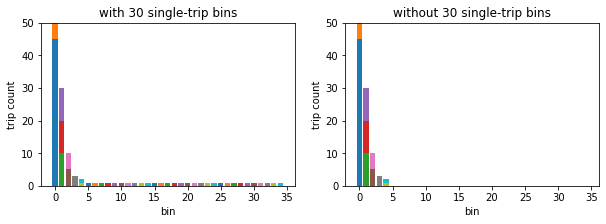

In [16]:
label_true = [0]*45 + [1]*5 + [2]*10 + [3]*10 + [4]*10 + [5]*5 + [6]*5 + [7]*3 + list(range(8, 40))
bin_pred = [1]*50 + [2]*30 + [3]*10 + [4]*3 + [5]*2 + list(range(6, 36))

df = pd.DataFrame(contingency_matrix(label_true, bin_pred, sparse=False))
df_chopped = df[:10]
dfs = [df, df_chopped]

fig, axs = plt.subplots(1, 2, figsize=(10,3))

for i in range(2):
    plot_stacked_bars(dfs[i], fig, axs[i])
    
axs[0].set_title("with 30 single-trip bins")
axs[1].set_title("without 30 single-trip bins")
print("H-score:\t", H_score(dfs[0]), "\t\t H-score:", H_score(dfs[1]))
print("modified H-score:", H_score_modified(dfs[0]), "\t modified H-score:", H_score_modified(dfs[1]))


An early idea to address the issue of single-trip bins artificially inflating H-scores was to compute the H-score only for the multi-trip bins. However, the concern was that the H-score would be artificially lowered and not capture the fact that we were still using the single-trip bins to make predictions. 

Notice that the modified H-score (0.753) for the left scenario is lower than its raw H-score (0.829) but higher than the score where the single-trip bins were entirely excluded (0.651). (This seems good, and supports the usage of this modified H-score over the earlier idea.) 

In both scenarios, the modified H-score is lower than the raw H-score, as expected and desired. Also interesting to note is that the gap between modified and raw H-scores is bigger on the left, where the 30 single-trip bins disproportionately affected the raw H-score. The gap is smaller on the right because we didn't have all those single-trip bins to skew our results. 

We can also compare the H-score for singular clusters from this example data to get a more granular view of what the modifications are doing:

H-score:
[0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
modified H-score:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


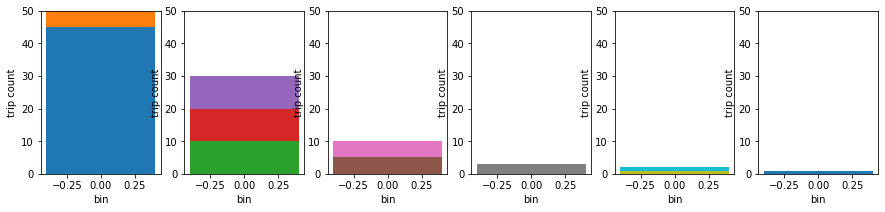

In [91]:
label_true = [0]*45 + [1]*5 + [2]*10 + [3]*10 + [4]*10 + [5]*5 + [6]*5 + [7]*3 + list(range(8, 40))
bin_pred = [1]*50 + [2]*30 + [3]*10 + [4]*3 + [5]*2 + list(range(6, 36))
df = pd.DataFrame(contingency_matrix(label_true, bin_pred, sparse=False))
H_scores = []
modified_H_scores = []

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    plot_stacked_bars(df.iloc[:,[i]], fig, axs[i])
    axs[i].set_ylim(0, 50)
    H_scores += [H_score(df.iloc[:,[i]])]
    modified_H_scores += [H_score_modified(df.iloc[:,[i]])]

print("H-score:")
print(H_scores)
print("modified H-score:")
print(modified_H_scores)


In [82]:
# label_true = [0]*45 + [1]*5 + [2]*10 + [3]*10 + [4]*10 + [5]*5 + [6]*5 + [7]*3 + list(range(8, 40))
# bin_pred = [1]*50 + [2]*30 + [3]*10 + [4]*3 + [5]*2 + list(range(6, 36))
# df = pd.DataFrame(contingency_matrix(label_true, bin_pred, sparse=False))

H_scores = []
modified_H_scores = []

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    temp_df = df.iloc[:,[i, i+1]]
    plot_stacked_bars(temp_df, fig, axs[i])
    axs[i].set_ylim(0, 50)
    H_scores += [H_score(temp_df)]
    modified_H_scores += [H_score_modified(temp_df)]

print("H-score:")
print(H_scores)
print("modified H-score:")
print(modified_H_scores)


0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [85]:
print(H_score(df.iloc[:,[0]]))
print(H_score(df.iloc[:,[1]]))
print(H_score(df.iloc[:,[2]]))
print(H_score(df.iloc[:,[3]]))
print(H_score(df.iloc[:,[4]]))
print(H_score(df.iloc[:,[5]]))
print(H_score(df.iloc[:,[6]]))

0.0
0.0
0.0
1.0
0.0
1.0
1.0


In [81]:
print(H_score_modified(df.iloc[:,[0, 1]]))
print(H_score_modified(df.iloc[:,[1, 2]]))
print(H_score_modified(df.iloc[:,[2, 3]]))
print(H_score_modified(df.iloc[:,[3, 4]]))
print(H_score_modified(df.iloc[:,[4, 5]]))
print(H_score_modified(df.iloc[:,[5, 6]]))

0.5036782754131408
0.3399714466848355
0.41360129762684605
0.45959877251022296
0.30501249975961464
0.3690702464285426


In [86]:
print(H_score(df.iloc[:,[0, 1]]))
print(H_score(df.iloc[:,[1, 2]]))
print(H_score(df.iloc[:,[2, 3]]))
print(H_score(df.iloc[:,[3, 4]]))
print(H_score(df.iloc[:,[4, 5]]))
print(H_score(df.iloc[:,[5, 6]]))

0.5181742207643957
0.3605680553151701
0.5032672074087368
0.708231644803283
0.579380164285695
1.0
